In [1]:
import enum
import typing
import abc
import itertools
import dataclasses
from pathlib import Path
from types import SimpleNamespace

import attrs
import numpy as np
from IPython import display

from arc25.dsl import types, primitives
from arc25.dsl import api as dsl
from arc25 import tools, dataset, sandbox, symmetry, prompts

In [2]:
proj_root = Path("..").resolve()
data_path = proj_root / "data"
db_root = data_path / "solutions"


In [3]:
ds = await dataset.Dataset.from_binary(data_path / "all-challenges.cbor.xz")
len(ds.challenges), sorted(ds.subsets)

(1307,
 ['all',
  'arc-agi-1',
  'arc-agi-1.evaluation',
  'arc-agi-1.training',
  'arc-agi-2',
  'arc-agi-2.evaluation',
  'arc-agi-2.training',
  'concept-arc',
  'harc',
  'harc.evaluation',
  'harc.training',
  'larc'])

In [4]:
solutions = await dataset.SolutionDB.load(db_root)
sol_with_code = sorted(k for k,v in solutions.solutions.items() if v.rule)
print(len(solutions.solutions), len(sol_with_code))
print(sol_with_code)

46 37
['00576224', '36fdfd69', '3af2c5a8', '4612dd53', '46442a0e', '54d82841', '5614dbcf', '642d658d', '6e19193c', '6f8cd79b', '72322fa7', '7bb29440', '8eb1be9a', '97999447', '9841fdad', '9f5f939b', 'a740d043', 'bf699163', 'ca-00-01', 'ca-00-10', 'ca-03-02', 'ca-03-04', 'ca-05-03', 'ca-08-01', 'ca-09-01', 'ca-10-04', 'ca-12-02', 'ca-14-05', 'ca-14-06', 'ca-15-10', 'cbded52d', 'ce039d91', 'd931c21c', 'e1d2900e', 'ea32f347', 'f9d67f8b', 'fd02da9e']


In [31]:
ckey = "ca-03-02"
chal = ds.challenges[ckey]
sol = solutions.solutions[ckey]
resp = prompts.parse_explanation(sol)
display.display(display.Markdown(sol.explanation))
display.display(display.Markdown(f"```python\n{resp.rule_impl}\n```"))

**Hypothesis:**
- Black background.
- One horizontal and one vertical colored dotted line.
- Impossible to say which of the two is painted over the other.

**Rule:**
- Start either from the input, or a fully black canvas of the same shape.
- First, paint a solid vertical line at the position and in the color of the dotted vertical line in the input.
- Second, paint a solid horizontal line at the position and in the color of the dotted horizontal line in the input.

**Plan:**
- There are no distractions, so we can determine the line positions simply from the count of foreground cells.


```python
def solution(input: Canvas) -> Canvas:
    output = input
    h,w = input.shape
    # identify foreground cells
    fg_mask = ~mask_color(input, BLACK)
    # paint all columns with more than one foreground cell
    # (there will be just one)
    for col in range(w):
        col_mask = mask_col(input, col)
        mask = col_mask & fg_mask
        if mask.count()>1:
            c, = most_common_colors(apply_mask(input, mask))
            output = fill(output, c, clip=col_mask)
    # same for the row
    for row in range(h):
        row_mask = mask_row(input, row)
        mask = row_mask & fg_mask
        if mask.count()>1:
            c, = most_common_colors(apply_mask(input, mask))
            output = fill(output, c, clip=row_mask)
    return output
```

In [25]:
enc = prompts.PromptEncoder()

print(enc.encode_response(resp))

<descr>hypothesis
- Black background.
- One horizontal and one vertical colored dotted line.
- Impossible to say which of the two is painted over the other.
</descr>
<rule>
- Start either from the input, or a fully black canvas of the same shape.
- First, paint a solid vertical line at the position and in the color of the dotted vertical line in the input.
- Second, paint a solid horizontal line at the position and in the color of the dotted horizontal line in the input.
</rule>
<plan>
- There are no distractions, so we can determine the line positions simply from the count of foreground cells.
</plan>
<impl>```python
def solution(input: Canvas) -> Canvas:
    output = input
    h,w = input.shape
    # identify foreground cells
    fg_mask = ~mask_color(input, BLACK)
    # paint all columns with more than one foreground cell
    # (there will be just one)
    for col in range(w):
        col_mask = mask_col(input, col)
        mask = col_mask & fg_mask
        if mask.count()>1:
      

In [8]:
print(enc.encode_response(prompts.ReasonedSolution(
    descr=dict(inputs="...",hypothesis="..."),
    rule_descr="...",
    impl_plan_descr="...",
    rule_impl="""
def solution(input: Canvas) -> Canvas:
    # TODO: implement rule
    return output
    """
)))

<descr>inputs
...
</descr>
<descr>hypothesis
...
</descr>
<rule>
...
</rule>
<plan>
...
</plan>
<impl>```python
def solution(input: Canvas) -> Canvas:
    # TODO: implement rule
    return output
```</impl>


In [9]:
import re
for c in types.Color:
    print(f"{c.name.lower()}:")
    rex = re.compile(r".{0,2}\b("+re.escape(c.name.lower())+r")\b.{0,2}",re.I)
    for ckey, sol in solutions.solutions.items():
        words = [m.group(0) for m in rex.finditer(sol.explanation)]
        code = [m.group(0) for m in rex.finditer(sol.rule)]
        if not (words or code):
            continue
        print(f"{ckey} w={len(words)} c={len(code)}: {words} {code}")

black:
ca-00-01 w=1 c=4: ['- Black b'] [', BLACK)', 'l-black l', 'n black', ', BLACK, ']
97999447 w=0 c=1: [] [', BLACK)']
a740d043 w=1 c=1: ['y black c'] ['e=BLACK, ']
ca-00-10 w=1 c=3: ['n black b'] ['e black p', ', BLACK))', 'e=BLACK)']
ca-14-06 w=0 c=2: [] ['e=BLACK),', 'l=BLACK)']
ca-03-04 w=1 c=3: ['- Black b'] ['n-black)', 't,BLACK)', ', BLACK, ']
ce039d91 w=1 c=1: ['n black b'] [', BLACK)']
d931c21c w=1 c=1: ['n black b'] ['e=BLACK):']
ca-12-02 w=1 c=3: ['n black b'] ['e=BLACK)', 'e=BLACK)', ', BLACK)']
ea32f347 w=1 c=0: ['n black b'] []
72322fa7 w=3 c=1: ['- Black b', 'n-black c', 'o black/b'] [', BLACK)']
ca-09-01 w=1 c=1: ['- Black b'] ['e=BLACK):']
8eb1be9a w=1 c=2: ['n black b'] ['n-black c', ', BLACK)']
ca-03-02 w=2 c=1: ['- Black b', 'y black c'] [', BLACK)']
642d658d w=1 c=0: ['n black'] []
4612dd53 w=4 c=1: ['- Black b', 'y black o', 'd black c', 'h black ('] [', BLACK)']
ca-10-04 w=2 c=2: ['- Black b', 'l black o'] ['= BLACK', ', BLACK, ']
ca-05-03 w=1 c=1: ['n black 

In [20]:
all_colors_rex.subn?

Signature: all_colors_rex.subn(repl, string, count=0)
Docstring: Return the tuple (new_string, number_of_subs_made) found by replacing the leftmost non-overlapping occurrences of pattern with the replacement repl.
Type:      builtin_method

{<Color.BLACK: '#000000'>: <Color.ORANGE: '#FF851B'>, <Color.BLUE: '#0074D9'>: <Color.GREEN: '#2ECC40'>, <Color.RED: '#FF4136'>: <Color.RED: '#FF4136'>, <Color.GREEN: '#2ECC40'>: <Color.CYAN: '#7FDBFF'>, <Color.YELLOW: '#FFDC00'>: <Color.GRAY: '#AAAAAA'>, <Color.GRAY: '#AAAAAA'>: <Color.MAGENTA: '#F012BE'>, <Color.MAGENTA: '#F012BE'>: <Color.BROWN: '#870C25'>, <Color.ORANGE: '#FF851B'>: <Color.YELLOW: '#FFDC00'>, <Color.CYAN: '#7FDBFF'>: <Color.BLACK: '#000000'>, <Color.BROWN: '#870C25'>: <Color.BLUE: '#0074D9'>}


**Hypothesis:**
- Orange background.
- One horizontal and one vertical colored dotted line.
- Impossible to say which of the two is painted over the other.

**Rule:**
- Start either from the input, or a fully orange canvas of the same shape.
- First, paint a solid vertical line at the position and in the color of the dotted vertical line in the input.
- Second, paint a solid horizontal line at the position and in the color of the dotted horizontal line in the input.

**Plan:**
- There are no distractions, so we can determine the line positions simply from the count of foreground cells.


```python
def solution(input: Canvas) -> Canvas:
    output = input
    h,w = input.shape
    # identify foreground cells
    fg_mask = ~mask_color(input, ORANGE)
    # paint all columns with more than one foreground cell
    # (there will be just one)
    for col in range(w):
        col_mask = mask_col(input, col)
        mask = col_mask & fg_mask
        if mask.count()>1:
            c, = most_common_colors(apply_mask(input, mask))
            output = fill(output, c, clip=col_mask)
    # same for the row
    for row in range(h):
        row_mask = mask_row(input, row)
        mask = row_mask & fg_mask
        if mask.count()>1:
            c, = most_common_colors(apply_mask(input, mask))
            output = fill(output, c, clip=row_mask)
    return output
```

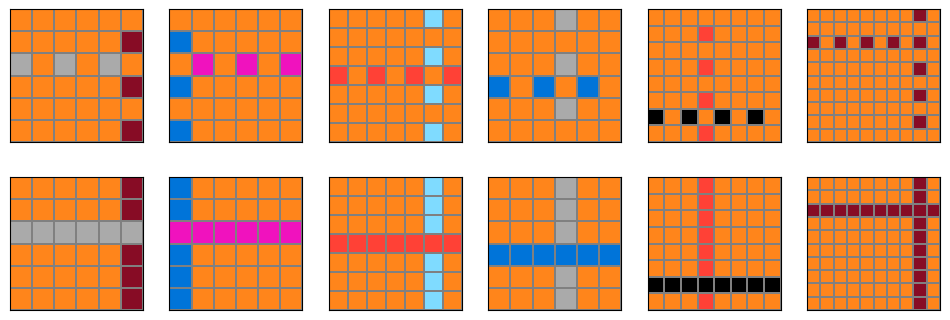

In [33]:
import dataclasses
import random


all_colors_rex = re.compile(r"\b("+"|".join(re.escape(c.name.lower()) for c in types.Color)+r")\b",re.I)
def permute_colors(arg, mapping: dict[types.Color, types.Color]) -> dataset.Challenge:
    imap = np.array([types._color2index[mapping.get(c,c)] for c in types.Color])
    smap = {
        style(c.name):style(mapping.get(c,c).name)
        for c in types.Color
        for style in [str.title, str.lower, str.upper]
    }
    assert (np.unique(imap) == np.r_[:10]).all()
    def apply(obj, strs=None, path=()):
        match obj:
            case dataset.Challenge():
                assert strs is None
                return attrs.evolve(obj, **apply(attrs.asdict(obj, recurse=False), False, path))
            case dataset.Solution():
                assert strs is None
                return attrs.evolve(obj, **apply(attrs.asdict(obj, recurse=False), True, path))                
            case prompts.ReasonedSolution():
                assert strs is None
                return attrs.evolve(obj, **apply(attrs.asdict(obj, recurse=False), True, path))                
            case types.Image() | types.MaskedImage():
                return dataclasses.replace(obj, _data=imap[obj._data])
            case _ if dataclasses.is_dataclass(obj):
                return dataclasses.replace(obj, **{f.name:apply(getattr(obj,f.name),strs,path+(f.name,)) for f in dataclasses.fields(obj)})
            case _ if attrs.has(obj):
                return attrs.evolve(obj, **apply(attrs.asdict(obj, recurse=False), strs, path))
            case str():
                if strs:
                    return all_colors_rex.sub(
                        lambda m: smap.get(m.group(1)),
                        obj,
                    )
                return obj
            case None | int() | types.SymOp():
                return obj
            case list() | tuple():
                return type(obj)(apply(v,strs,path+(f"[{i}]",)) for i,v in enumerate(obj))
            case dict():
                return {k:apply(v,strs,path+(k,)) for k,v in obj.items()}
            case _:
                raise TypeError(f"Unknown object of type {type(obj).__name__} at {'.'.join(path)}")
    return apply(arg)


rgen = random.Random(42)
colors = list(types.Color)
rgen.shuffle(colors)
mapping = dict(zip(types.Color,colors))
print(mapping)

cpchal = permute_colors(chal,mapping)
cpsol = permute_colors(sol,mapping)
cpresp = prompts.parse_explanation(cpsol)
display.display(display.Markdown(cpsol.explanation))
display.display(display.Markdown(f"```python\n{cpresp.rule_impl}\n```"))
tools.show_test_case(
    cpchal.train + cpchal.test,
    orientation = "h",
)
assert cpresp == permute_colors(resp, mapping)
